**Installations**

In [1]:
%%capture --no-stderr
!pip install faiss-gpu faiss-cpu ipaddress tqdm openai tiktoken
!pip install langchain langchain-openai langchain-community langchain-tavily langgraph langgraph-supervisor openevals agentevals langsmith
!pip install pypdf
!pip install neo4j
!pip install pycountry

In [2]:
# !sudo apt-get update
# !sudo apt-get install -y curl apt-transport-https ssl-cert ca-certificates gnupg lsb-release
# !curl -1sLf 'https://dl.cloudsmith.io/public/wand/libwandio/cfg/setup/bash.deb.sh' | sudo -E bash
# !echo "deb https://pkg.caida.org/os/$(lsb_release -si|awk '{print tolower($0)}') $(lsb_release -sc) main" | sudo tee /etc/apt/sources.list.d/caida.list
# !sudo wget -O /etc/apt/trusted.gpg.d/caida.gpg https://pkg.caida.org/os/ubuntu/keyring.gpg
# !sudo apt update; sudo apt-get install bgpstream

In [3]:
# !pip install pybgpstream
# !python3 -m pip install pybgpkit-parser
# !python3 -m pip install pybgpkit

**Mounting Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/LLM4BGP

Mounted at /content/drive
/content/drive/MyDrive/LLM4BGP


**Importing Dependencies**

In [5]:
import getpass
from pandas import DataFrame
import os
import json
import ast
import re
import yaml
import sys
from pathlib import Path
import subprocess
import matplotlib.pyplot as plt
from prompts import *
from single_agents.tor_agent import *

In [6]:
from evaluations.lang_smith_aux_tor import *
from langsmith import wrappers
from langsmith import Client
from langsmith import aevaluate

**API Keys Management**

In [7]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [8]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")

Enter your LangSmith API key: ··········


In [9]:
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_PROJECT'] = 'test'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'

In [10]:
client = Client()
client = Client(api_key=os.environ['LANGSMITH_API_KEY'])

**Q & A Dataset Loading**

In [11]:
# Path to your file
file_path = "datasets/tor/as_rels_qas.json"

# Load JSON
with open(file_path, "r", encoding="utf-8") as f:
    q_a_dataset = json.load(f)

In [12]:
dataset = ensure_tor_dataset(client, q_a_dataset, dataset_name="AS ToR Inference Q&A dataset")

In [13]:
# Fetch the dataset already created in LangSmith
datasets = [ds for ds in client.list_datasets() if ds.name == "AS ToR Inference Q&A dataset"]
dataset = datasets[0] if datasets else None


# Convert generator to list so we can slice
all_examples = list(client.list_examples(dataset_id=dataset.id))
dataset_examples = all_examples

In [14]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

model = ChatOpenAI(model_name="gpt-4.1")

**Agentic RAG for Retreival of BGP Information From Revelant Papers**

In [15]:
# chunk_size = 1000
# chunk_overlap = 200
# retriever_tool = build_retriever_tools("datasets/papers", chunk_size, chunk_overlap, k=2)

# # Sanity check for retrieving tool
# print(retriever_tool.invoke({"query": "What are the 3 types of relationships between ASNs? Answer shortly"}))

**Model Architecture**

In [16]:
from tools.iyp.iyp_tools import *

In [17]:
PROMPT_FILE = Path("prompts/ToR/tor_prompts.yaml")

with PROMPT_FILE.open(encoding="utf-8") as fp:
    prompts = yaml.safe_load(fp)

In [18]:
bgp_general_prompt = prompts["bgp_general_prompt"]
caida_tor_prompt = prompts["caida_tor_prompt"]
caida_prompt = prompts["caida_prompt"]
whois_tor_prompt = prompts["whois_tor_prompt"]
peeringdb_tor_prompt = prompts["peeringdb_tor_prompt"]
routeviews_tor_prompt = prompts["routeviews_tor_prompt"]

In [19]:
# This is the Agent which has to be called, it can be ReAct Agent, Hierarchical Multi-Agent System, Plan-and-Execute or any other type.
def create_tor_react_agent(data_tools, prompt):
    model = ChatOpenAI(model_name="gpt-4.1")
    tor_agent = create_react_agent(
        model=model,
        tools=data_tools,
        prompt=prompt
    )
    return tor_agent

In [24]:
agent = create_tor_react_agent([get_caida_tor], caida_tor_prompt)
graph = create_workflow(agent, model, ["CAIDA_ToR"])

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

**Datasets Update**

In [26]:
# from datasets.datasets_preparation import *

In [27]:
# download_recent_as_rels()

# **Single Data Source**

In [28]:
from tools.caida.caida_tools import *

**CAIDA ToR**

Generic BGP Prompt

In [ ]:
agent = create_tor_react_agent([get_caida_tor], bgp_general_prompt)
graph = create_workflow(agent, model, [])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_Generic_Prompt_CAIDA_TOR_tool",
    judge_model="o3-mini",
)

ToR Prompt

In [ ]:
agent = create_tor_react_agent([get_caida_tor], caida_tor_prompt)
graph = create_workflow(agent, model, ["CAIDA_ToR"])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_CAIDA_TOR_tool-4.1",
    judge_model="o3-mini",
)

**CAIDA AS Rank**

Generic BGP Prompt

In [ ]:
agent = create_tor_react_agent(caida_as_rank_tools, bgp_general_prompt)
graph = create_workflow(agent, model, ['CAIDA'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_Generic_Prompt_CAIDA_AS_Rank_tools",
    judge_model="o3-mini",
)

ToR Prompt

In [ ]:
agent = create_tor_react_agent(caida_as_rank_tools, caida_prompt)
graph = create_workflow(agent, model, ['CAIDA'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_AS_Rank_tools",
    judge_model="o3-mini",
)

**Whois**

In [29]:
from tools.whois.whois_tools import *

Generic BGP Prompt

In [130]:
agent = create_tor_react_agent(whois_tools, bgp_general_prompt)
graph = create_workflow(agent, model, [])

In [131]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_Generic_Prompt_Whois_tools",
    judge_model="o3-mini",
)

View the evaluation results for experiment: 'ToR_Generic_Prompt_Whois_tools-7df81c6a' at:
https://smith.langchain.com/o/d3cb8df4-aea8-404a-b7f7-3c7ee52670a1/datasets/c3f7dcfe-c8b0-483f-b452-08f37733f16f/compare?selectedSessions=4a3fe439-3b6e-4432-93b5-2b4d05d92f4c




0it [00:00, ?it/s]

Yes.
----
Yes.
----
{
  "query": {"asn1": 702, "asn2": 4837},
  "relationship": "",
  "provider": null,
  "customer": null,
  "reasoning": "Used import policies for both AS702 and AS4837. Only import rules from AS702 regarding AS4837 were found; no policy info found in the reverse direction. The information is insufficient to infer a p2c or p2p relationship directly.",
  "notes": "Cannot unambiguously determine relationship from import data alone."
}
[ToR_agent tools used]: are_connected, as_imports_with_other_asn
----
OBSERVER: INVALID — relationship must be one of {'p2c','p2p','c2p'}; provider must be a valid ASN; customer must be a valid ASN; answer_uncertain_or_invalid_relationship; missing_required_tools — WHOIS: as_exports_with_other_asn, get_as_remarks, whois_as
ACTION: ToR_agent — retry and output a strict JSON object with keys [relationship, provider, customer, reasoning] (reasoning must be a list of strings) and no extra prose.
----
{
  "query": {"asn1": 702, "asn2": 25213},


KeyboardInterrupt: 

In [154]:
question  = "What is the type of relationship between the following ASes: AS9299, AS7629? You MUST return an answer of p2c or p2p."
query_agent(question, agent)


----
[]
----
[]
----
{
  "query": {"asn1": 9299, "asn2": 7629},
  "relationship": "",
  "provider": null,
  "customer": null,
  "reasoning": "Attempted to retrieve import rules for both AS9299 and AS7629; no relationship data was available from the sources.",
  "notes": "Unable to verify relationship type between AS9299 and AS7629 due to lack of data."
}
----


'{\n  "query": {"asn1": 9299, "asn2": 7629},\n  "relationship": "",\n  "provider": null,\n  "customer": null,\n  "reasoning": "Attempted to retrieve import rules for both AS9299 and AS7629; no relationship data was available from the sources.",\n  "notes": "Unable to verify relationship type between AS9299 and AS7629 due to lack of data."\n}'

ToR Prompt

In [111]:
agent = create_tor_react_agent(whois_tools, whois_tor_prompt)
graph = create_workflow(agent, model, ['WHOIS'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_Whois_tools",
    judge_model="o3-mini",
)

**PeeringDB**

In [66]:
from tools.peeringdb.peeringdb_tools import *

Generic BGP Prompt

In [67]:
agent = create_tor_react_agent( pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, bgp_general_prompt)
graph = create_workflow(agent, model, ['PEERING_DB'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_Generic_Prompt_CAIDA_PeeringDB_tools",
    judge_model="o3-mini",
)

ToR Prompt

In [97]:
agent = create_tor_react_agent(pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, peeringdb_tor_prompt)
graph = create_workflow(agent, model, ['PEERING_DB'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_PeeringDB_tools",
    judge_model="o3-mini",
)

**Routes**

In [31]:
from tools.routes.routes_tools import *

Generic BGP Prompt

In [45]:
agent = create_tor_react_agent([get_random_routes_with_asns], bgp_general_prompt)
graph = create_workflow(agent, model, ['ROUTES'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_Generic_Prompt_Routes_tool",
    judge_model="o3-mini",
)

ToR Prompt

In [58]:
agent = create_tor_react_agent([get_random_routes_with_asns], routeviews_tor_prompt)
graph = create_workflow(agent, model, ['ROUTES'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_Routes_tool",
    judge_model="o3-mini",
)

# **Multiple Data Sources**

In [ ]:
vf_caida_tor_prompt = prompts["vf_caida_tor_prompt"]
whois_caida_policy_tor_prompt = prompts["whois_caida_policy_tor_prompt"]
peeringdb_caida_tor_prompt = prompts["peeringdb_caida_tor_prompt"]
multi_source_tor_prompt = prompts["multi_source_tor_prompt"]
peering_db_whois_prompt = prompts["peering_db_whois_prompt"]
peering_db_routes_prompt = prompts["peering_db_routes_prompt"]

**Combining AS Rank with Routes**

Generic BGP Prompt

In [ ]:
# agent = create_tor_react_agent([get_random_routes_with_asns] + caida_as_rank_tools, bgp_general_prompt)
# graph = create_workflow(agent, model, ['CAIDA', 'ROUTES'])

In [ ]:
# run_langsmith_eval(
#     client,
#     dataset_examples,
#     graph,
#     experiment_prefix="ToR_Generic_Prompt_CAIDA_Routes_tools",
#     judge_model="o3-mini",
# )

ToR Prompt

In [ ]:
agent = create_tor_react_agent([get_random_routes_with_asns] + caida_as_rank_tools, vf_caida_tor_prompt)
graph = create_workflow(agent, model,  ['CAIDA', 'ROUTES'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_CAIDA_Routes_tools",
    judge_model="o3-mini",
)

**Combining CAIDA and whois**

Generic BGP Prompt

In [ ]:
# agent = create_tor_react_agent(caida_as_rank_tools + whois_tools, bgp_general_prompt)
# graph = create_workflow(agent, model, ['CAIDA', 'WHOIS'])

In [ ]:
# run_langsmith_eval(
#     client,
#     dataset_examples,
#     graph,
#     experiment_prefix="ToR_Generic_Prompt_CAIDA_Whois_tools",
#     judge_model="o3-mini",
# )

ToR Prompt

In [ ]:
agent = create_tor_react_agent(caida_as_rank_tools + whois_tools, whois_caida_policy_tor_prompt)
graph = create_workflow(agent, model, ['CAIDA', 'WHOIS'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_CAIDA_Whois_tools",
    judge_model="o3-mini",
)

**Combining CAIDA with PeeringDB**

Generic BGP Prompt

In [ ]:
# agent = create_tor_react_agent(caida_as_rank_tools + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, bgp_general_prompt)
# graph = create_workflow(agent, model, ['CAIDA', 'PeeringDB'])

In [ ]:
# run_langsmith_eval(
#     client,
#     dataset_examples,
#     graph,
#     experiment_prefix="ToR_Generic_Prompt_CAIDA_PeeringDB_tools",
#     judge_model="o3-mini",
# )

ToR Prompt

In [ ]:
agent = create_tor_react_agent(caida_as_rank_tools + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, peeringdb_caida_tor_prompt)
graph = create_workflow(agent, model, ['CAIDA', 'PeeringDB'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_CAIDA_PeeringDB_tools",
    judge_model="o3-mini",
)

**PeeringDB and Whois**

In [ ]:
agent = create_tor_react_agent(whois_tools + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, peering_db_whois_prompt)
graph = create_workflow(agent, model, ['WHOIS', 'PeeringDB'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_PeeringDB_Whois_tools",
    judge_model="o3-mini",
)

**PeeringDB and Routes**

In [ ]:
agent = create_tor_react_agent([get_random_routes_with_asns] + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, peering_db_routes_prompt)
graph = create_workflow(agent, model, ['ROUTES', 'PeeringDB'])

In [ ]:
run_langsmith_eval(
    client,
    dataset_examples,
    graph,
    experiment_prefix="ToR_ToR_Prompt_PeeringDB_Routes_tools",
    judge_model="o3-mini",
)

**Combining All Data Sources**

Generic BGP Prompt

In [ ]:
# agent = create_tor_react_agent([get_random_routes_with_asns] + whois_tools + caida_as_rank_tools + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, bgp_general_prompt)
# graph = create_workflow(agent, model, ['CAIDA', ' WHOIS', 'PeeringDB', 'ROUTES'])

In [ ]:
# run_langsmith_eval(
#     client,
#     dataset_examples,
#     graph,
#     experiment_prefix="ToR_Generic_Prompt_CAIDA_PeeringDB_Whois_Routes_tools",
#     judge_model="o3-mini",
# )

ToR Prompt

In [ ]:
# agent = create_tor_react_agent([get_random_routes_with_asns] + whois_tools + caida_as_rank_tools + pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools, multi_source_tor_prompt)
# graph = create_workflow(agent, model)

In [ ]:
# run_langsmith_eval(
#     client,
#     dataset_examples,
#     graph,
#     experiment_prefix="ToR_ToR_Prompt_CAIDA_PeeringDB_Whois_Routes_tools",
#     judge_model="o3-mini",
# )

In [ ]:
from typing import Any, Dict, List, Optional, Literal
from typing_extensions import TypedDict, Annotated
import operator
import json
import re
from single_agents.tor_agent import *
from single_agents.tor_agent import _tools_called_in_messages
from single_agents.tor_agent import connectivity_check_node, _normalize_yes_no
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

In [ ]:
CAIDA_PROMPT = prompts["caida_tor_workflow_prompt"]
WHOIS_PROMPT = prompts["whois_tor_workflow_prompt"]
PEERINGDB_PROMPT = prompts["peeringdb_tor_workflow_prompt"]
ROUTES_PROMPT = prompts["routes_tor_workflow_prompt"]
REASONER_PROMPT = prompts["reasoner_workflow_prompt"]

In [ ]:
REASONER_PROMPT = """
    ROLE
    You are the final inter-AS Type-of-Relationship (ToR) REASONER.
    Fuse the four source payloads (CAIDA, WHOIS, PeeringDB, ROUTES) that were produced by earlier nodes.
    Use ONLY the information inside the provided JSON input. Do NOT call tools.

    TASK
    Given two Autonomous System Numbers (ASNs), classify their relationship as exactly one of:
      • "p2c"  = provider → customer (directional)
      • "peers" = peer ↔ peer (undirected)
    You MUST output one of these two values in every case; do not abstain. When evidence is thin or mixed, follow the tie-breakers below.

    INPUT (STRICT SCHEMA)
    You will receive a single JSON object with keys:
      - "asn1": <int>, "asn2": <int>
      - "caida": {
          "query": {"asn1": <int>, "asn2": <int>},
          "asn1 info": {
            "as_rank": <int|null>, "as_cone_size": <int|null>, "as2country": <str|null>,
            "as_peers_num": <int|null>, "as_providers_num": <int|null>, "as_transit_num": <int|null>,
            "as_degree": <int|null>, "additional_data": <obj|omit>
          },
          "asn2 info": { /* same keys as asn1 info */ }
        }
      - "whois": {
          "query": {"asn1": <int>, "asn2": <int>},
          "asn1 info": {
            "imports_with_other": {"total": <int>, "any": <int>},
            "exports_to_other":   {"total": <int>, "any": <int>},
            "remarks_keywords":   [<str>, ...],
            "whois_text_snippet": <str>,
            "additional_data": <obj|omit>
          },
          "asn2 info": { /* same keys as asn1 info */ }
        }
      - "peeringdb": {
          "query": {"asn1": <int>, "asn2": <int>},
          "asn1 info": {
            "policy_general": <str|null>, "policy_ratio": <str|null>, "policy_locations": <str|null>,
            "ix_count": <int|null>, "rs_peer_count": <int|null>, "speeds": [<int or str>, ...],
            "info_scope": <str|null>, "prefixes4": <int|null>, "prefixes6": <int|null>,
            "as_set": <str|null>, "notes": <str|null>, "aka": [<str>, ...],
            "as_type": <str|null>, "as_types": [<str>, ...], "deployed_fac_count": <int>,
            "additional_data": <obj|omit>
          },
          "asn2 info": { /* same keys as asn1 info */ }
        }
      - "routes": {
          "query": {"asn1": <int>, "asn2": <int>},
          "routes info": {"total_paths": <int>, "a_before_b": <int>, "b_before_a": <int>},
          "samples": <list[str or list[int]]>
        }

    HEURISTICS & REASONING GUIDELINES

    A) WHOIS / IRR semantics (highest-confidence when AS-specific and one-sided)
      • Treat only explicit, AS-specific RPSL of the form “import: from AS{other} accept ANY/DEFAULT” or “export: to AS{other} announce ANY/DEFAULT” as decisive transit signals.
        – Generic “from ANY” or imports/exports of AS‑SETs (e.g. “import AS‑RETN”) are not a transit signal and must be ignored.
        – If exactly one side contains such AS‑specific ANY/DEFAULT and the reverse does not, infer p2c with the importer as CUSTOMER and the other as PROVIDER.
      • Remarks keywords (“upstream”, “transit”, “provider”, “customer”) help only if consistent with an AS‑specific import/export ANY/DEFAULT. Disregard boilerplate or stale text in WHOIS snippets.

    B) PeeringDB posture (primary peer/transit discriminator; leverage all fields qualitatively)
      • Assign highest weight to TWO‑SIDED, SYMMETRIC declarations across the fields below. Symmetry should default to “peers” unless strong contradictory evidence exists.
      • `policy_general` + `policy_ratio` + `policy_contracts`: “Open/Selective” with “Ratio: No” and “Contracts: Not Required” on both sides supports peering. One‑sided “Restrictive/Contracts Required” weakly indicates transit only when combined with clear asymmetry in other signals.
      • `policy_locations` / IX/facility overlap: overlapping regions/cities/IXPs on BOTH sides supports feasible p2p; no overlap weakens peering only when WHOIS and routes provide strong p2c signals.
      • `ix_count` & `deployed_fac_count`: large numbers on both sides (with overlap) support p2p; extreme one‑sidedness suggests p2c only with corroboration from WHOIS or routes. Use `rs_peer_count` to confirm shared route‑server participation; RS‑only adjacencies are NOT transit evidence.
      • `speeds`, `traffic_levels`, `prefixes4`, `prefixes6` and `as_cone_size` from CAIDA indicate scale/capacity; use only as footprint context. **Never equate “bigger” with “provider‑likeness” by itself.**
      • `info_scope` (Global/International/Regional/National): symmetry supports p2p; “Regional/National” vs “Global” asymmetry leans p2c only with WHOIS or route corroboration.
      • `as_type` / `as_types`: content↔NSP or CDN↔NSP often peer even with scale differences; enterprise↔NSP less likely. Use only as a weak hint within the context of other signals.
      • `as_set` / `irr_as_set`: useful to align with IRR but not directional on its own.
      • `notes`, `aka`, `policy_url`, `looking_glass`, `status_dashboard`: operator‑declared policies can corroborate peering (e.g., “announce only own and customers (not peers/providers)”); if absent or marketing‑oriented, treat as weak.

    C) ROUTES (valley‑free orientation; strict, non‑RS corroboration)
      • Clean paths by ignoring prepending and non‑ASNs; count direction only when ASNs are adjacent (“… A B …” ⇒ A→B).
      • Consider route orientation decisive only when ALL are true:
          – Appearances are exclusively one‑way across a substantial sample of non‑RS paths (ignore route‑server only samples); AND
          – This does not contradict peer‑symmetric PeeringDB and neutral WHOIS; AND
          – Multiple non‑RS BGP collectors/vantage points show the same one‑way orientation.
      • One‑way samples confined to route servers, mixed or thin samples, or balanced adjacencies must be treated as peer‑like and cannot justify p2c on their own.

    D) CAIDA structure cues (tie‑breaker only; never primary)
      • Use CAIDA fields (`as_rank`, `as_cone_size`, `as_degree`, number of providers/peers/transit) only to break ties when WHOIS and PeeringDB provide no transit signals and routes are balanced or absent.
      • A clear provider‑likeness gap (e.g., one AS has no upstreams, significantly higher degree/cone size) can support p2c only when combined with WHOIS AS‑specific ANY/DEFAULT or a restrictive PeeringDB posture. Never rely on CAIDA size differences alone.

    E) Fusion priority (PeeringDB/WHOIS‑first; require multiple signals)
      1) When PeeringDB on both sides is peer‑symmetric (Open/Selective, Ratio: No, Contracts: Not Required) and WHOIS is neutral (no AS‑specific ANY/DEFAULT), choose “peers” unless routes provide exclusive, non‑RS one‑way evidence AND PeeringDB is asymmetric.
      2) If WHOIS shows AS‑specific one‑way ANY/DEFAULT, choose p2c (direction by importer/exporter) unless PeeringDB is strongly peer‑symmetric AND routes are balanced/mixed (then prefer p2p and note tension).
      3) To decide p2c without (2), require at least two independent transit signals, **and CAIDA cannot be one of them**. Valid combinations include:
          (i) Exclusive, non‑RS one‑way routes PLUS PeeringDB posture asymmetry (restrictive/no‑peering on the smaller side or open vs selective with strong scale gap); or
          (ii) Exclusive one‑way routes PLUS WHOIS partial transit hints (imports/exports ANY/DEFAULT referencing the other AS); or
          (iii) WHOIS AS‑specific import/export ANY/DEFAULT PLUS PeeringDB transit posture (restrictive/no‑peering).
          Do not use CAIDA + routes alone as sufficient evidence for p2c.
      4) If routes are thin or mixed and WHOIS is neutral, fall back to PeeringDB and CAIDA: clear provider‑likeness plus restrictive PeeringDB on one side ⇒ p2c; clear symmetry or transit‑free posture on both ⇒ p2p.
      5) If evidence suggests p2c somewhere but p2p at IX (e.g. RS peering at shared IX with asymmetric WHOIS), prefer the relationship supported by WHOIS + non‑RS routes and record any conflicts in notes.

    F) Tier‑1 / transit‑free prior (peer‑protective)
      • TIER1_SET = {1299, 2914, 3257, 3356, 701, 7018, 6453, 6762, 5511, 3491, 3320, 6461, 6830, 12956}.
      • If both ASNs are in TIER1_SET ⇒ default to “peers” unless WHOIS shows explicit AS‑specific ANY/DEFAULT or routes show exclusive, non‑RS one‑way adjacencies.
      • If exactly one is in TIER1_SET ⇒ never classify the Tier‑1 as customer. Require strong transit evidence (WHOIS + routes) to mark it provider; otherwise (with symmetric PeeringDB/WHOIS and non‑decisive routes) prefer p2p.
      • If CAIDA shows upstreams for a Tier‑1, or PeeringDB/WHOIS show paid transit, treat the Tier‑1 prior as stale and fall back to rules A–E.

    G) Decision & tie‑breakers (you MUST choose)
      • Choose “peers” when there is no clear one‑way transit signal AND at least two independent symmetry signals agree (e.g. symmetric PeeringDB + balanced/mixed routes; or symmetric PeeringDB + symmetric CAIDA).
      • Otherwise choose “p2c”, with the provider being the more provider‑like side (larger cone/tier, fewer upstream providers, more restrictive policy). Always state which signals decided the outcome and note any limitations (e.g. RS‑only routes, small sample size, generic AS‑SET imports).

    Special considerations
      • Same-org/AKA is not decisive by itself; do not infer siblings here.
      • Country or geography alone is not decisive.
      • Treat nulls/missing as “no evidence”.

    REASONING LINE (style)
    One concise sentence naming the deciding cues, e.g.:
      – “WHOIS one-way ‘any’ A→B; CAIDA/PeeringDB show B clearly larger → p2c (B provider).”
      – “Open/Selective on both; many shared IXes/RS; CAIDA shows similar scale; routes mixed → peers.”
      – “Routes consistently A→B; WHOIS neutral; CAIDA shows B much larger → p2c (B provider).”

    CONSTRAINTS
    - Only output one of: "p2c" or "peers".
    - When "p2c", provider and customer must be one of the two ASNs; for "peers", both are null.
    - Be concise and do not invent data not present in the inputs.
    - Output must match the schema below exactly; no extra keys.

    OUTPUT FORMAT (STRICT; plain JSON, no code fences)
    {
      "query": {"asn1": <int>, "asn2": <int>},
      "relationship": "<p2c|peers>",
      "provider": <int or null>,
      "customer": <int or null>,
      "reasoning": "<one short sentence on which signals decided it>",
      "notes": "<short optional note on conflicts/limits or empty string>"
    }
"""

In [ ]:
_MANDATORY_TOOLS: dict[str, list[str]] = {
    "CAIDA": [
        "as_rank",
        "as_cone_size",
        "as2country",
        "as_peers_num",
        "as_providers_num",
        "as_transit_num",
        "as_degree",
    ],
    "WHOIS": [
        "as_imports_with_other_asn",
        "as_exports_with_other_asn",
        "whois_as",
        "get_as_remarks",
    ],
    "PEERING_DB": [
        "get_as_deployed_inf_data",
        "get_asn_aka",
        "pdb_get_as_as_set",
        "get_net_notes",
        "get_netixlan_data",
        "get_net_traffic_data_for_asn",
        "pdb_as_type_info_type",
        "pdb_as_type_info_types",
        "get_net_policy_data",
    ],
    "ROUTES": [
        "get_random_routes_with_asns",
    ],
}

In [ ]:
_TOOL_REGISTRY: dict[str, Any] = {
    # CAIDA
    "as_rank": as_rank,
    "as_cone_size": as_cone_size,
    "as2country": as2country,
    "as_peers_num": as_peers_num,
    "as_providers_num": as_providers_num,
    "as_transit_num": as_transit_num,
    "as_degree": as_degree,

    # WHOIS
    "as_imports_with_other_asn": as_imports_with_other_asn,
    "as_exports_with_other_asn": as_exports_with_other_asn,
    "whois_as": whois_as,
    "get_as_remarks": get_as_remarks,

    # PEERING_DB
    "get_as_deployed_inf_data": get_as_deployed_inf_data,
    "get_asn_aka": get_asn_aka,
    "pdb_get_as_as_set": pdb_get_as_as_set,
    "get_net_notes": get_net_notes,
    "get_netixlan_data": get_netixlan_data,
    "get_net_traffic_data_for_asn": get_net_traffic_data_for_asn,
    "pdb_as_type_info_type": pdb_as_type_info_type,
    "pdb_as_type_info_types": pdb_as_type_info_types,
    "get_net_policy_data": get_net_policy_data,

    # ROUTES
    "get_random_routes_with_asns": get_random_routes_with_asns,
}

In [ ]:
def _safe_tool_call(fn, *args, retries: int = 2) -> bool:
    """Best-effort tool call; returns True if the call succeeded without raising."""
    for _ in range(retries + 1):
        try:
            # Keep using positional call to avoid LangChain schema mismatch issues
            _ = fn(*args)
            return True
        except Exception:
            pass
    return False

In [ ]:
def _resolve_asn_pair(state) -> tuple[Optional[str], Optional[str]]:
    """Return (asn1, asn2) from state, falling back to parsing from messages.
    Prevents KeyError when external callers don't pre-populate asn1/asn2.
    """
    a1 = state.get("asn1") if isinstance(state, dict) else None
    a2 = state.get("asn2") if isinstance(state, dict) else None
    if a1 and a2:
        return a1, a2

    msgs = state.get("messages", []) if isinstance(state, dict) else []
    text = " ".join(_coalesce_content(m) for m in msgs) if msgs else ""
    asns = re.findall(r"(?i)\b(?:AS|asn)?\s*(\d{1,10})\b", text)
    if not a1 and len(asns) >= 1:
        a1 = asns[0]
    if not a2 and len(asns) >= 2:
        a2 = asns[1]
    return a1, a2

In [ ]:
class OrchestratorState(TypedDict):
    asn1: str
    asn2: str
    connectivity: str | None
    caida: dict | None
    whois: dict | None
    peeringdb: dict | None
    routes: dict | None
    tools_used: Annotated[set[str], operator.or_]
    tools_per_node: Annotated[dict[str, list[str]], operator.or_]
    final_text: str | None
    decision: dict | None
    messages: Annotated[list, operator.add]

In [ ]:
def _coalesce_content(msg_obj):
    if hasattr(msg_obj, "content"):
        content = msg_obj.content
    elif isinstance(msg_obj, tuple) and len(msg_obj) >= 2:
        content = msg_obj[1]
    elif isinstance(msg_obj, dict):
        content = msg_obj.get("content", "")
    else:
        content = str(msg_obj)
    if isinstance(content, list):
        parts = []
        for p in content:
            if isinstance(p, dict) and "text" in p:
                parts.append(str(p["text"]))
            else:
                parts.append(str(p))
        content = "".join(parts)
    return str(content)

In [ ]:
def _extract_json_payload(text):
    if not text:
        return None
    m = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", text, flags=re.S | re.I)
    if m:
        return m.group(1)
    if isinstance(text, str) and text.startswith("VALID\n"):
        _, rest = text.split("\n", 1)
        return _extract_json_payload(rest)
    start = text.find("{")
    if start == -1:
        return None
    depth = 0
    for i in range(start, len(text)):
        ch = text[i]
        if ch == "{":
            depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return text[start : i + 1]
    return None

In [ ]:
def _enforce_mandatory_calls(source: str, used: set[str], asn1: int, asn2: int) -> set[str]:
    """
    Minimal, model-agnostic enforcement to guarantee all mandatory tools are executed.
    - CAIDA: call each unary tool for both ASNs if missing.
    - WHOIS: always ensure both directional imports/exports *and* whois/remarks for both ASNs.
    - PEERING_DB: call each unary tool for both ASNs if missing.
    - ROUTES: ensure the pair tool is called for (asn1, asn2).
    """
    source = "PEERING_DB" if source == "PEERING_DB" else source.upper()
    must = _MANDATORY_TOOLS.get(source, [])

    # Helper to resolve tool by name
    def _t(name: str):
        fn = _TOOL_REGISTRY.get(name)
        if fn is None:
            raise RuntimeError(f"Required tool '{name}' not found in registry")
        return fn

    # CAIDA: unary calls
    if source == "CAIDA":
        for name in must:
            if name not in used:
                fn = _t(name)
                _safe_tool_call(fn, asn1)
                _safe_tool_call(fn, asn2)
                used.add(name)

    # WHOIS: enforce both directions for imports/exports, plus whois/remarks for both ASNs
    elif source == "WHOIS":
        # whois_as / get_as_remarks for both ASNs
        for name in ("whois_as", "get_as_remarks"):
            if name not in used:
                fn = _t(name)
                _safe_tool_call(fn, asn1)
                _safe_tool_call(fn, asn2)
                used.add(name)

        # Directional mandatory: ALWAYS ensure both directions are executed
        for name in ("as_imports_with_other_asn", "as_exports_with_other_asn"):
            fn = _t(name)
            _safe_tool_call(fn, asn1, asn2)
            _safe_tool_call(fn, asn2, asn1)
            used.add(name)

    # PEERING_DB: unary calls
    elif source == "PEERING_DB":
        for name in must:
            if name not in used:
                fn = _t(name)
                _safe_tool_call(fn, asn1)
                _safe_tool_call(fn, asn2)
                used.add(name)

    # ROUTES: pair call
    elif source == "ROUTES":
        name = "get_random_routes_with_asns"
        if name not in used:
            fn = _t(name)
            _safe_tool_call(fn, asn1, asn2)
            used.add(name)

    return used

In [ ]:
def _prompt_connectivity(a1: str, a2: str) -> str:
    return f"""
      ROLE
      You are a precise AS adjacency checker. Use the provided 'are_connected' tool only.
      Given two ASNs, answer 'YES' if they are directly connected (adjacent in BGP), otherwise 'NO'.
      Input will be "AS{a1} AS{a2}". Output strictly 'YES' or 'NO'. No extra text.
      """

In [ ]:
def _connectivity_node(state, model) -> Command:
    """Use the connectivity agent from tor_agent.py, but be resilient when 'asn1'/'asn2' are
    not present in the incoming state (e.g., when called via LangSmith eval).
    """
    a1, a2 = _resolve_asn_pair(state)
    if not a1 or not a2:
        # Can't proceed; avoid crash and short-circuit to stop the graph.
        return Command(update={
            "messages": state.get("messages", []),
            "connectivity": None,
        })

    ta_state = {"messages": [("user", f"AS{a1} AS{a2}")]}  # MessagesState-compatible
    cmd = connectivity_check_node(ta_state, model)

    updates = getattr(cmd, "update", {}) or {}
    msgs = updates.get("messages", [])

    last_text = _coalesce_content(msgs[-1]) if msgs else ""
    yn = _normalize_yes_no(last_text)

    if yn == "YES":
        connected = "YES"
    elif yn == "NO":
        connected = "NO"
    else:
        upper = last_text.upper()
        if "NO" in upper and "YES" not in upper:
            connected = "NO"
        elif "YES" in upper:
            connected = "YES" if upper.rfind("YES") > upper.rfind("NO") else "NO"
        else:
            connected = "YES"

    used = _tools_called_in_messages(msgs) or []

    return Command(update={
        "messages": state.get("messages", []) + msgs,
        "connectivity": connected,
        "tools_used": (state.get("tools_used", set()) | set(used)),
        "tools_per_node": {"connectivity": used},
    })

In [ ]:
def _source_node(state, model, source: str, tools, prompt) -> Command:
    from langgraph.prebuilt import create_react_agent
    from single_agents.tor_agent import _tools_called_in_messages

    a1, a2 = _resolve_asn_pair(state)
    if not a1 or not a2:
        # Avoid KeyError and skip this branch gracefully
        return Command(update={"messages": state.get("messages", [])})

    agent = create_react_agent(model, tools=tools, prompt=prompt)
    res = agent.invoke({"messages": [("user", f"AS{a1} AS{a2}")]})

    last = res["messages"][-1]
    content = _coalesce_content(last)

    raw = _extract_json_payload(content)
    if raw:
        try:
            payload = json.loads(raw)
        except Exception:
            payload = {"source": source, "raw": raw}
    else:
        payload = {"source": source, "raw": content}

    used = set(_tools_called_in_messages(res["messages"]) or [])
    used = _enforce_mandatory_calls(source, used, int(a1), int(a2))

    key = source.lower() if source != "PEERING_DB" else "peeringdb"
    return Command(update={
        key: payload,
        "tools_used": (state.get("tools_used", set()) | set(used)),
        "tools_per_node": {key: sorted(list(used))},
        "messages": state.get("messages", []) + res["messages"],
    })

In [ ]:
def _caida_node(state, model):
    # Give the agent the full CAIDA palette; enforcement guarantees mandatory coverage
    return _source_node(state, model, "CAIDA", caida_as_rank_tools, CAIDA_PROMPT)


def _whois_node(state, model):
    # Full WHOIS tool palette for the agent; enforcement guarantees directional pairs
    return _source_node(state, model, "WHOIS", whois_tools, WHOIS_PROMPT)


def _peeringdb_node(state, model):
    # Full PeeringDB palette (AS, orgs, carriers); enforcement will call all mandatories
    return _source_node(
        state,
        model,
        "PEERING_DB",
        pdb_ases_tools + pdb_orgs_tools + pdb_carrier_tools,
        PEERINGDB_PROMPT,
    )


def _routes_node(state, model):
    # Only one tool needed for Routes; still enforced as mandatory
    return _source_node(state, model, "ROUTES", [get_random_routes_with_asns], ROUTES_PROMPT)

In [ ]:
def _fanout_node(state, model) -> Command:
    # No-op node used to fan-out to multiple sources
    return Command(update={})

In [ ]:
def _reasoner_node(state, model):
    """Run only when all source payloads are present. Uses the passed-in model.
    Be defensive about 'asn1'/'asn2' presence.
    """
    if not (state.get("caida") and state.get("whois") and state.get("peeringdb") and state.get("routes")):
        return Command(update={})

    a1, a2 = _resolve_asn_pair(state)
    if not a1 or not a2:
        return Command(update={})

    bundle = {
        "asn1": int(a1),
        "asn2": int(a2),
        "caida": state.get("caida", {}),
        "whois": state.get("whois", {}),
        "peeringdb": state.get("peeringdb", {}),
        "routes": state.get("routes", {}),
    }

    agent = create_react_agent(model, tools=[], prompt=REASONER_PROMPT)
    res = agent.invoke({"messages": [("user", json.dumps(bundle))]})

    last = res["messages"][-1]
    content = _coalesce_content(last)

    raw = _extract_json_payload(content)
    payload = json.loads(raw) if raw else {
        "query": {"asn1": int(a1), "asn2": int(a2)},
        "relationship": "",
        "provider": None,
        "customer": None,
        "reasoning": "No valid JSON from reasoner.",
        "notes": "",
    }

    used = _tools_called_in_messages(res["messages"]) or []

    return Command(update={
        "decision": payload,
        "final_text": json.dumps(payload),
        "tools_used": (state.get("tools_used", set()) | set(used)),
        "messages": state.get("messages", []) + res["messages"],
    })

In [ ]:
def build_parallel_tor_graph(model):
    g = StateGraph(OrchestratorState)

    # Nodes
    g.add_node("connectivity", lambda s: _connectivity_node(s, model))
    g.add_node("fanout",       lambda s: Command(update={}))
    g.add_node("caida",        lambda s: _caida_node(s, model))
    g.add_node("whois",        lambda s: _whois_node(s, model))
    g.add_node("peeringdb",    lambda s: _peeringdb_node(s, model))
    g.add_node("routes",       lambda s: _routes_node(s, model))
    # CHANGED: pass `model` into _reasoner_node
    g.add_node("reasoner",     lambda s: _reasoner_node(s, model))

    # Start → connectivity
    g.add_edge(START, "connectivity")

    # Gate: only fan out if connected == YES
    def _go_or_stop(state) -> Literal["go", "stop"]:
        return "go" if state.get("connectivity") == "YES" else "stop"

    g.add_conditional_edges("connectivity", _go_or_stop, {"go": "fanout", "stop": END})

    # Fan-out
    g.add_edge("fanout", "caida")
    g.add_edge("fanout", "whois")
    g.add_edge("fanout", "peeringdb")
    g.add_edge("fanout", "routes")

    # Any source can trigger reasoner; _reasoner_node guards until all four present
    g.add_edge("caida", "reasoner")
    g.add_edge("whois", "reasoner")
    g.add_edge("peeringdb", "reasoner")
    g.add_edge("routes", "reasoner")

    g.add_edge("reasoner", END)

    return g.compile()


In [ ]:
graph = build_parallel_tor_graph(model)

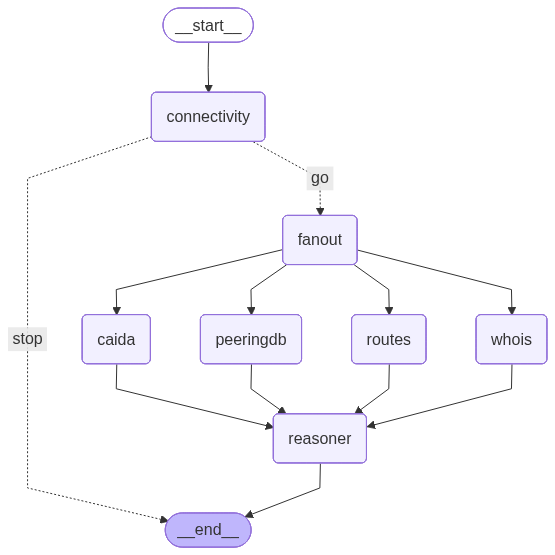

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def run_tor(graph, asn1: int | str, asn2: int | str, *, recursion_limit: int = 50):
    a1 = "".join(ch for ch in str(asn1) if ch.isdigit())
    a2 = "".join(ch for ch in str(asn2) if ch.isdigit())

    init = {
        "messages": [("system", "You are a precise ToR classification workflow.")],
        "asn1": a1,
        "asn2": a2,
        "connectivity": None,
        "caida": None,
        "whois": None,
        "peeringdb": None,
        "routes": None,
        "tools_used": set(),
        "tools_per_node": {},
        "final_text": None,
        "decision": None,
    }

    final_text = None
    last_msg_text = None

    for ev in graph.stream(init, config={"recursion_limit": recursion_limit}):
        if not ev:
            continue
        key = next(iter(ev), None)
        if not key:
            continue
        payload = ev.get(key, {}) if isinstance(ev, dict) else {}

        # Prefer the explicit final JSON produced by the reasoner
        ft = payload.get("final_text")
        if isinstance(ft, str) and ft.strip():
            final_text = ft

        # Fallback: remember the last LLM message text (legacy behavior)
        msgs = payload.get("messages", [])
        if msgs:
            last = msgs[-1]
            last_msg_text = _coalesce_content(last)

    if final_text:
        try:
            return json.loads(final_text)
        except Exception:
            pass

    if not last_msg_text:
        return {"error": "No output"}

    if isinstance(last_msg_text, str) and last_msg_text.startswith("VALID\n"):
        try:
            return json.loads(last_msg_text.split("\n", 1)[1])
        except Exception:
            pass

    raw = _extract_json_payload(last_msg_text if isinstance(last_msg_text, str) else str(last_msg_text))
    return json.loads(raw) if raw else {"error": "No final JSON produced"}

In [ ]:
def get_results(res: Optional[str]):
    if not res:
        return None
    m = re.search(r"\{[\s\S]*\}", res)
    if m:
        try:
            return json.loads(m.group())
        except Exception:
            return None
    return None

In [ ]:
# REPLACE the existing query_agent in single_agents/tor_agent.py with this version
def query_agent(question: str, graph, *, recursion_limit: int = 150):
    """Robust streaming printer that won't crash if a node yields None payloads.
    Returns the final_text (string) if produced by the reasoner, else an empty string.
    This version only changes the event loop guards and keeps the public surface the same.
    """
    import re

    # Extract ASNs (best-effort; empty strings if not present)
    asns = re.findall(r"(?i)\b(?:AS|asn)?\s*(\d{1,10})\b", question or "")
    a1 = asns[0] if len(asns) > 0 else ""
    a2 = asns[1] if len(asns) > 1 else ""

    init = {
        "messages": [("user", question or "")],
        "asn1": a1,
        "asn2": a2,
        "connectivity": None,
        "caida": None,
        "whois": None,
        "peeringdb": None,
        "routes": None,
        "tools_used": set(),
        "tools_per_node": {},
        "final_text": None,
        "decision": None,
    }

    results = None

    for s in graph.stream(init, config={"recursion_limit": recursion_limit}):
        # Each tick yields a dict like {node_key: update_dict}. Guard aggressively.
        if not isinstance(s, dict) or not s:
            continue
        key = next(iter(s), None)
        if not key:
            continue
        payload = s.get(key)
        if not isinstance(payload, dict):
            # Some nodes may emit `None`; just skip.
            continue

        print(f"[node: {key}] ----")
        per_node = payload.get("tools_per_node") or {}
        if isinstance(per_node, dict):
            tools_here = per_node.get(key) or per_node.get(key.lower())
            if tools_here:
                print(tools_here)

        ft = payload.get("final_text")
        if isinstance(ft, str) and ft.strip():
            results = ft

    return results or ""


In [ ]:
q = "What is the type of relationship between the following ASes: AS3300, AS9002?"
res_text = query_agent(q, graph)
parsed = get_results(res_text)

[node: connectivity] ----
['are_connected']
[node: caida] ----
['as2country', 'as_cone_size', 'as_degree', 'as_peers_num', 'as_providers_num', 'as_rank', 'as_transit_num']
[node: peeringdb] ----
['get_as_deployed_inf_data', 'get_asn_aka', 'get_net_notes', 'get_net_policy_data', 'get_net_traffic_data_for_asn', 'get_netixlan_data', 'pdb_as_type_info_type', 'pdb_as_type_info_types', 'pdb_get_as_as_set']


/tmp/ipython-input-21849211.py:6: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  _ = fn(*args)


[node: whois] ----
['as_exports_with_other_asn', 'as_imports_with_other_asn', 'get_as_remarks', 'whois_as']
[node: routes] ----
['get_random_routes_with_asns']
[node: reasoner] ----


In [ ]:
parsed

{'query': {'asn1': 3300, 'asn2': 9002},
 'relationship': 'p2c',
 'provider': 9002,
 'customer': 3300,
 'reasoning': 'Routes exclusively 9002→3300 across non-RS IXes; PeeringDB Selective/Not Required on both sides; WHOIS neutral.',
 'notes': 'All sampled BGP paths show 9002 before 3300, with no evidence of the reverse; no transit-specific WHOIS entries; PeeringDB and CAIDA both show clear scale asymmetry but do not outweigh the strong route orientation.'}

In [ ]:
from evaluations.lang_smith_aux_tor import (
    extract_normalized_from_transcript,
    llm_as_judge_eval,
    ensure_tor_dataset,
)

In [ ]:
def safe_query_agent(question: str, graph, *, recursion_limit: int = 150) -> str:
    """Stream the graph for a given question and return the final JSON string
    produced by the reasoner ("final_text"). Handles None payloads defensively.
    """
    # Extract ASNs (best-effort; empty strings if not present)
    asns = re.findall(r"(?i)\b(?:AS|asn)?\s*(\d{1,10})\b", question or "")
    a1 = asns[0] if len(asns) > 0 else ""
    a2 = asns[1] if len(asns) > 1 else ""

    init = {
        "messages": [("user", question or "")],
        "asn1": a1,
        "asn2": a2,
        "connectivity": None,
        "caida": None,
        "whois": None,
        "peeringdb": None,
        "routes": None,
        "tools_used": set(),
        "tools_per_node": {},
        "final_text": None,
        "decision": None,
    }

    results: str | None = None

    for tick in graph.stream(init, config={"recursion_limit": recursion_limit}):
        if not isinstance(tick, dict) or not tick:
            continue
        key = next(iter(tick), None)
        if not key:
            continue
        payload = tick.get(key)
        if not isinstance(payload, dict):
            # Some nodes may emit `None`; just skip.
            continue
        ft = payload.get("final_text")
        if isinstance(ft, str) and ft.strip():
            results = ft

    return results or ""

In [ ]:
def make_target_for_graph(graph):
    def _target(inputs: Dict[str, Any]) -> Dict[str, Any]:
        q = inputs.get("question", "")
        transcript = safe_query_agent(q, graph)
        norm, path = extract_normalized_from_transcript(transcript or "")
        return {"transcript": transcript, "normalized": norm or {}, "parse_path": path}
    return _target

In [ ]:
def ensure_or_read_dataset(client: Client, dataset_name: str) -> Any:
    """Return an existing LangSmith dataset by name, or create it from
    the built-in Q&A in your environment (if you've wired that up).
    Falls back to `ensure_tor_dataset` which expects a list of QAs.
    """
    try:
        return client.read_dataset(dataset_name=dataset_name)
    except Exception:
        # If the dataset doesn't exist yet, try to build it via your helper.
        # Expecting a variable `qas` in scope where this is used; otherwise
        # users can call `ensure_tor_dataset(client, qas, dataset_name)` directly.
        raise RuntimeError(
            f"Dataset '{dataset_name}' not found. "
            "Either create it in LangSmith first or call "
            "ensure_tor_dataset(client, qas, dataset_name)."
        )

In [ ]:
def run_eval_new_agent(
    client: Client,
    dataset: Any,
    graph,
    *,
    experiment_prefix: str = "tor-multi-agent",
    judge_model: str = "o3-mini",
) -> None:
    """Run LangSmith evaluation for the *new* agent.

    This mirrors `run_langsmith_eval` from the helper, but swaps in a
    target that calls our robust `safe_query_agent` to avoid None
    payload crashes.
    """
    evaluators: List[Any] = [llm_as_judge_eval(judge_model)]

    client.evaluate(
        make_target_for_graph(graph),
        data=dataset,
        evaluators=evaluators,
        experiment_prefix=experiment_prefix,
        max_concurrency=2,
    )

In [ ]:
run_eval_new_agent(
    client,
    dataset,
    graph,
    experiment_prefix="ToR_ToR_Prompt_CAIDA_PeeringDB_Whois_Routes_tools",
    judge_model='o3-mini',
    )

View the evaluation results for experiment: 'ToR_ToR_Prompt_CAIDA_PeeringDB_Whois_Routes_tools-ec167123' at:
https://smith.langchain.com/o/d3cb8df4-aea8-404a-b7f7-3c7ee52670a1/datasets/c3f7dcfe-c8b0-483f-b452-08f37733f16f/compare?selectedSessions=35208dd5-eb4e-488c-b5ce-7d5dcc1a2813




0it [00:00, ?it/s]